In [47]:
%matplotlib inline
import glob
import random
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
import seaborn as sns
from matplotlib.pyplot import imshow

from scipy.interpolate import UnivariateSpline

import cv2
import skimage
from skimage.filters import gaussian
from skimage.external import tifffile
from skimage.measure import label, regionprops
from skimage.transform import rotate
matplotlib.rcParams['figure.figsize'] = (78, 30.0)

In [2]:
def get_imset_num(path):
    return path.split('/')[2].split('_')[0]

def get_wavelength_imset_paths(wavelength):
    return sorted([glob.glob('raw_data/imgs/%s*_%d_1*' % (i, wavelength))[0] for i in set([get_imset_num(s) for s in glob.glob('raw_data/imgs/*')])],
                  key=lambda path: get_imset_num(path))

daf7 = pd.read_csv('raw_data/labels/0_daf-7.dat')
gld1 = pd.read_csv('raw_data/labels/1_gld-1_RNAi.dat')
glp1 = pd.read_csv('raw_data/labels/2_glp-1_gf.dat')
hm_0 = pd.read_csv('raw_data/labels/3_HM_08_03.dat')
hm_1 = pd.read_csv('raw_data/labels/4_HM_08_15.dat')
hm_2 = pd.read_csv('raw_data/labels/5_HM_08_23.dat')
hm_3 = pd.read_csv('raw_data/labels/6_HM_08_25.dat')

# The movement labels are in different columns for each file, this gets the appropriate column from each
all_labels = np.asarray(pd.concat([
    daf7['Definite Movement Calls 410/470'],
    gld1['Def Movement Call 410/470'],
    glp1['Movement 470/470'],
    hm_0['Movement 470/470'],
    hm_1['Movement 470/470'],
    hm_2['Movement 470/470'],
    hm_3['Movement 470/470']],
    ignore_index=True
), dtype=int)



_410_img_paths = get_wavelength_imset_paths(410)
_470_img_paths = get_wavelength_imset_paths(470)

all_410 = np.concatenate([tifffile.imread(_410_img_paths[i]) for i in range(len(_410_img_paths))], axis=0)
all_470 = np.concatenate([tifffile.imread(_470_img_paths[i]) for i in range(len(_470_img_paths))], axis=0)

# Images are bad for various reasons (two worms/image, etc.)
problem_ims = [1156, 1157, 1158, 1151]

# Can't use NaNs as labels
problem_labels = np.where(np.isnan(all_labels))[0]

problem_idx = np.append(problem_labels, problem_ims)

# Remove the problem items from each stack
all_410 = np.delete(all_410, problem_idx, axis=0)
all_470 = np.delete(all_470, problem_idx, axis=0)
all_labels = np.delete(all_labels, problem_idx)

# Process Images

## First, we threshold the images

In [3]:
def remove_all_but_rightmost(img):
    """Expects a binary img"""
    L = label(img, connectivity=1)
    if not ((img==0) | (img==1)).all():
        raise ValueError('Image is not binary')
        
    rightmost_reg = max(
        [reg for reg in regionprops(L)], key=lambda r: r.bbox[3]
    )
    L[L != rightmost_reg.label] = 0
    L[L != 0] = 1
    return L


def threshold(img):
    thresh = img > 1200
    thresh = remove_all_but_rightmost(thresh)
    return thresh

bin_410 = np.asarray([threshold(img) for img in all_410]).astype(np.uint16)
bin_470 = np.asarray([threshold(img) for img in all_470]).astype(np.uint16)

## Next, we rotate each image, using the binary images to tell us the orientation

In [4]:
def get_rot_angle(img, is_bin=True):
    if not is_bin:
        img = make_bin_mask(img)
    L = label(img)
    R = regionprops(L)[0]
    return -math.degrees(R.orientation)

rot_angles = [get_rot_angle(img) for img in bin_410]

# We need to rotate the image around the center of the pharynx
centers_410 = [regionprops(label(img))[0].centroid[::-1] for img in bin_410]

In [5]:
rot_410, rot_470 = zip(*[
    (
        rotate(img_410, ang, preserve_range=True, mode='constant', cval=0.01, center=center_410), 
        rotate(img_470, ang, preserve_range=True, mode='constant', cval=0.01, center=center_410)
    ) for ang, img_410, img_470, center_410 in zip(rot_angles, all_410, all_470, centers_410)])
rot_410 = np.asarray(rot_410)
rot_470 = np.asarray(rot_470)

## And now we threshold the rotated image

In [6]:
bin_rot_410 = np.asarray([threshold(img) for img in rot_410], dtype=np.uint16)
bin_rot_470 = np.asarray([threshold(img) for img in rot_470], dtype=np.uint16)

## Filter out pharynges that are too close to the edge

In [7]:
def make_bbox(I, buffer=2):
    """
    Bounding box (min_row, min_col, max_row, max_col).
    
    Pixels belonging to the bounding box are in the half-open 
    interval [min_row; max_row) and [min_col; max_col).
    """
    R = regionprops(label(I))[0]
    min_row, min_col, max_row, max_col = R.bbox
    return min_row, min_col, max_row + 1, max_col + 1


def is_central_enough(B):
    if set([0, 1]) != set(np.ravel(B)):
        raise ValueError('Image is not binary')
    min_row, min_col, max_row, max_col = make_bbox(B)
    return ((min_row > 10) and (min_col > 10) and (max_row < np.shape(B)[0] - 10) and (max_col < np.shape(B)[1] - 10))
            
central_enough_mask = [is_central_enough(B) for B in bin_rot_410]

c_bin_rot_410 = bin_rot_410[central_enough_mask]
c_rot_410 = rot_410[central_enough_mask]
c_rot_470 = rot_470[central_enough_mask]
c_labels = all_labels[central_enough_mask]

## Crop, using bounding box from rotated 410nm binary image

In [8]:
def make_crop_box(B):
    min_row, min_col, max_row, max_col = make_bbox(B)
    return min_row - 5, min_col - 5, min_row + 20, min_col + 60

    
def crop_im(img, bbox):
    minr, minc, maxr, maxc = bbox
    return img[minr:maxr, minc:maxc]


c_bboxes_410 = [make_crop_box(img) for img in c_bin_rot_410]

cropped_410 = [crop_im(img, bbox) for img, bbox in zip(c_rot_410, c_bboxes_410)]
cropped_470 = [crop_im(img, bbox) for img, bbox in zip(c_rot_470, c_bboxes_410)]

## Calculate ratio images

In [9]:
r_410_470 = np.divide(cropped_410, cropped_470)
r_410_470_norm = (r_410_470 - np.mean(r_410_470.ravel())) / np.std(r_410_470.ravel())

In [10]:
np.mean(r_410_470.ravel())

1.2363793977082338

## Make label images (for browsing with ImageJ)

In [11]:
y = np.genfromtxt('proc_data/central_labels.txt', dtype=int)

In [12]:
import cv2

def make_label_im(label):
    # Create a black image
    img = np.zeros((50,50,3), np.uint8)
    # Write some Text
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (14,35)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    cv2.putText(img,str(label), 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)
    return img

label_ims = np.asarray([make_label_im(label) for label in y]).astype(np.uint8)
tifffile.imsave('proc_data/label_ims.tiff', label_ims)

# Save Data

In [13]:
tifffile.imsave('proc_data/cropped_410.tiff', np.asarray(cropped_410).astype(np.float32))
tifffile.imsave('proc_data/cropped_470.tiff', np.asarray(cropped_470).astype(np.float32))

tifffile.imsave('proc_data/r_410_470.tiff', np.asarray(r_410_470).astype(np.float32))
tifffile.imsave('proc_data/r_410_470_norm.tiff', np.asarray(r_410_470_norm).astype(np.float32))

tifffile.imsave('proc_data/label_ims.tiff', label_ims)
np.savetxt('proc_data/central_labels.txt', c_labels.astype(np.int), fmt='%d')

In [14]:
def com_per_col(img):
    n = img.shape[0]
    i = np.arange(n).reshape([n, 1])
    return np.sum(np.divide(img * i, axis=0), np.sum(img, axis=0))

In [15]:
def draw_polyline(img):
    I = img.copy()
    blurred = skimage.filters.gaussian(img, sigma=1.1, preserve_range=True)
#     blurred = threshold(img)
    pts = list(zip(np.arange(len(com_per_col(blurred))), com_per_col(blurred)))
    cv2.polylines(img=I, pts=[pts], isClosed=False, color=(255,255,255))
    return I

    
def get_polyline(img, should_round=True):
    I = img.copy()
    blurred = gaussian(img, sigma=1.1, preserve_range=True)
    with np.errstate(divide='ignore'):
        poly =  np.nan_to_num(np.asarray(list(zip(x, com_per_col(blurred)))))
        if should_round:
            return poly.astype(np.int)
        else:
            return poly

# poly_lines_470_blur = np.asarray([draw_polyline(img) for img in cropped_470], dtype=np.float32)

# tifffile.imsave('proc_data/poly_lines_470_blur.tiff', poly_lines_470_blur)

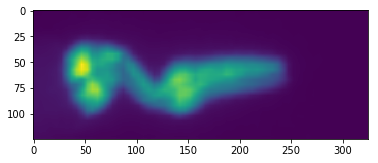

In [16]:
plt.imshow(skimage.transform.resize(cropped_410[29], np.round(np.multiply(5, np.shape(cropped_410[29]))), mode='reflect'))

In [17]:
np.multiply(2, np.shape(cropped_410[29]))

array([ 50, 130])

In [18]:
# pts = get_polyline(threshold(skimage.transform.resize(cropped_410[29], np.round(np.multiply(5, np.shape(cropped_410[29]))), mode='reflect')), should_round=False)

# x = pts[:,0]
# y = pts[:,1]

# f = interp1d(x, y)
# f2 = interp1d(x, y, kind='quadratic')
# xnew = np.linspace(0, len(y)-1, num=100)
# spl = UnivariateSpline(x, y, k=4)
# spl.set_smoothing_factor(1)

# der = spl.derivative()

# first_minima = der.roots()[0]
# last_minima = der.roots()[-1]


# minimas = [first_minima, last_minima]

# fig, ax = plt.subplots()

# ax.plot(x, 24-y, 'o')
# # ax.plot(xnew, 24-f2(xnew), '--')
# ax.plot(xnew, 24-spl(xnew))
# # ax.plot(minimas, 24-spl(minimas), 'o', markersize=20, color='red')

# # ax.plot(x, 24-y, 'o', xnew, 24-f2(xnew), '--', xnew, 24-spl(xnew), '-', last_minima, 24-spl(last_minima), 'x', first_minima, 24-spl(first_minima), 'x')
# ax.legend(['data', 'cubic', 'spline'], loc='best')

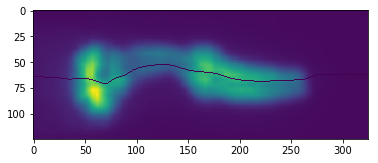

In [19]:
# Img = skimage.transform.resize(cropped_410[26], np.round(np.multiply(5, np.shape(cropped_410[29]))), mode='reflect')

def upsample(img):
    return skimage.transform.resize(img, np.round(np.multiply(5, np.shape(img))), mode='reflect')

def com_per_col(img):
    n = img.shape[0]
    i = np.arange(n).reshape([n, 1])
    return np.sum(img * i, axis=0) / np.sum(img, axis=0)


def get_polyline(img, should_round=True):
    with np.errstate(divide='ignore'):
        poly = np.nan_to_num(np.asarray(list(zip(np.arange(Img.shape[1]), com_per_col(img)))))
    if should_round:
        return poly.astype(np.int)
    else:
        return poly


def draw_polyline(img, pts):
    """Pts are an array of y values"""
    I = img.copy()
    cv2.polylines(img=I, pts=[pts], isClosed=False, color=(0,255,0))
    return I

def get_max_col(img):
    """Expects a NON-binary image"""
    return regionprops(label(threshold(img)))[0].bbox[3]


def get_min_col(img):
    """Expects a NON-binary image"""
    return regionprops(label(threshold(img)))[0].bbox[1]


Img = upsample(cropped_410[26])

plt.imshow(draw_polyline(
    Img,
    get_polyline(Img)
))

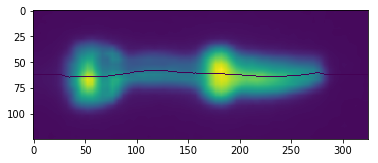

In [20]:
def highpass(img, n=1400):
    I = img.copy()
    I[I<n] = 0.0001
    return I

Img = upsample(cropped_410[25])
# Img = cropped_410[180]

plt.imshow(draw_polyline(Img, get_polyline(highpass(Img, 1400))))

(<matplotlib.axes._subplots.AxesSubplot at 0x1202c9b00>,
 <scipy.interpolate.fitpack2.UnivariateSpline at 0x1202c9400>)

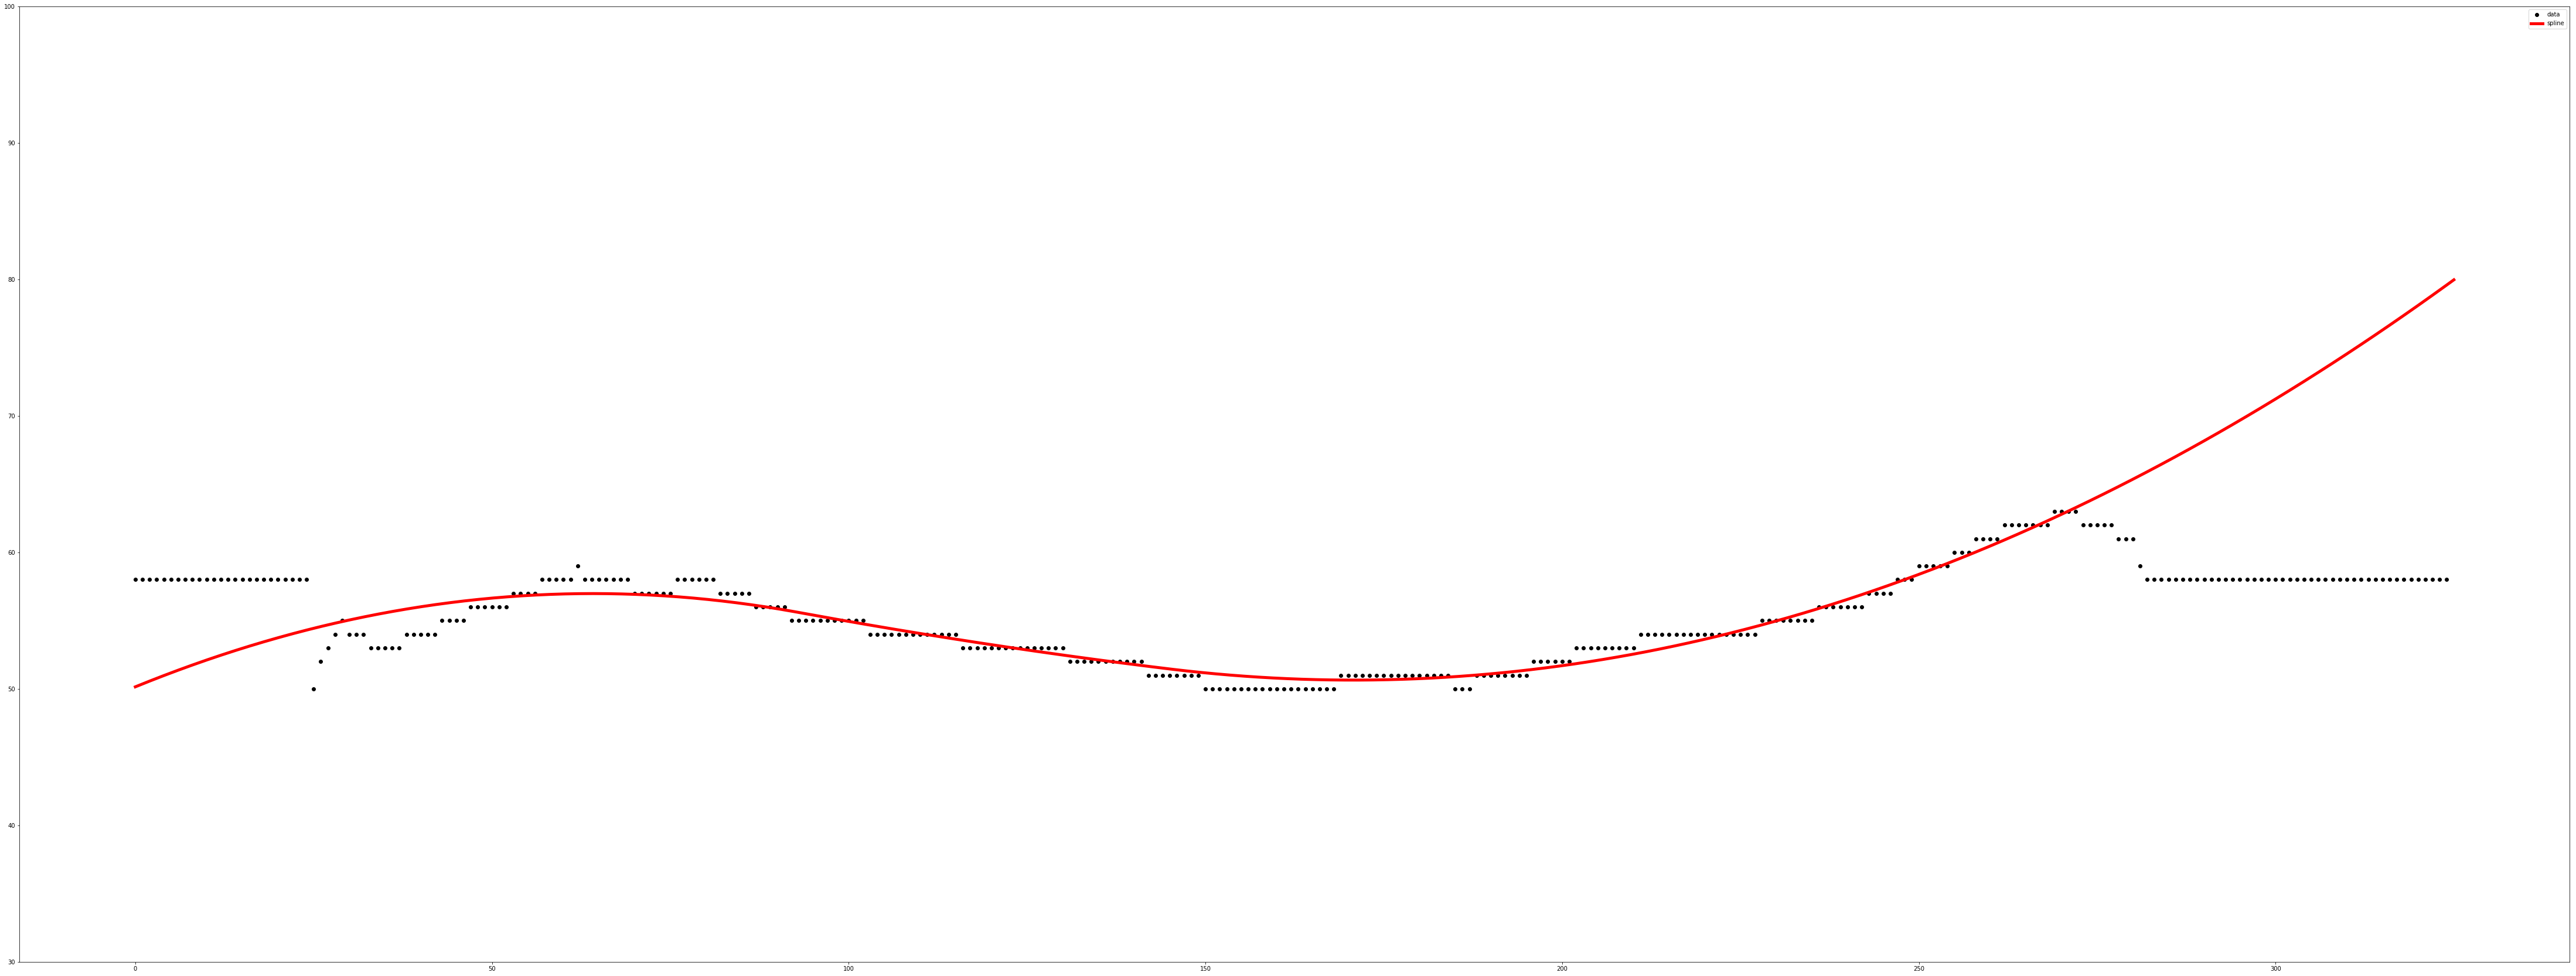

In [58]:
def plot_polyline(polyline, ax=None):
    x = polyline[:, 0]
    y = polyline[:, 1]
#     y = y[x>25]
#     x = x[x>25]
    
    spl = UnivariateSpline(x[40:250], y[40:250], k=2)
    spl.set_smoothing_factor(100)

    xnew = np.linspace(0, 325, num=325)

    if not ax:
        fig, ax = plt.subplots()
    
    ax.plot(x, 120-y, 'o', color='black')
    ax.plot(xnew, 120-spl(xnew), color='red', linewidth=5.0)
    
    ax.set_ylim([30,100])
    
    ax.legend(['data', 'spline'], loc='best')
    return (ax, spl)



Img = upsample(cropped_410[88])
plot_polyline(get_polyline(highpass(Img, 1200), should_round=True))

In [22]:
def fit_spline(polyline):
    x = polyline[:, 0]
    y = polyline[:, 1]
    spl = UnivariateSpline(x, y, k=2)
    spl.set_smoothing_factor(100)
    return spl

In [23]:
def draw_spline_polyline(img):
    u_img = upsample(img)
    polyline = get_polyline(highpass(u_img, 1200), should_round=True)[get_min_col(u_img)+10:get_max_col(u_img)-10]
    spl = fit_spline(polyline)
    pts = np.asarray(list(zip(np.arange(Img.shape[1]), np.round(spl(np.arange(Img.shape[1]))))), dtype=np.int)
    return draw_polyline(u_img, pts)

In [24]:
spline_lines_410 = [draw_spline_polyline(img) for i, img in enumerate(cropped_410) if i < 50]



In [25]:
tifffile.imsave('proc_data/spline_lines_410.tiff', np.asarray(spline_lines_410).astype(np.float32))

In [26]:
spline_lines_470 = [draw_spline_polyline(img) for i, img in enumerate(cropped_470) if i < 50]

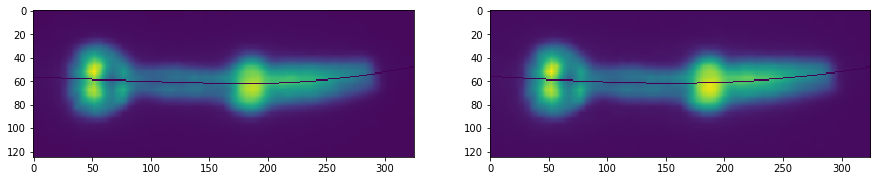

In [27]:
fig = plt.figure(figsize=(15,25))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

idx = 17
ax1.imshow(spline_lines_410[idx])
ax2.imshow(spline_lines_470[idx])

In [28]:
def get_spline_line(img):
    u_img = upsample(img)
    polyline = get_polyline(highpass(u_img, 1200), should_round=True)[get_min_col(u_img)+10:get_max_col(u_img)-10]
    spl = fit_spline(polyline)
    return spl(np.arange(u_img.shape[1]))

splines_410 = np.asarray([get_spline_line(img) for i, img in enumerate(cropped_410) if i < 75])
splines_470 = np.asarray([get_spline_line(img) for i, img in enumerate(cropped_470) if i < 75])

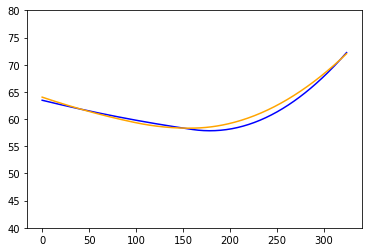

In [29]:
x = np.arange(splines_410.shape[1])

idx = 17

fig = plt.figure()
ax = fig.gca()

ax.plot(x, 120-splines_410[idx],c='blue')
ax.plot(x, 120-splines_470[idx],c='orange')


ax.set_ylim(40,80)
ax.suptitle = "TEST"

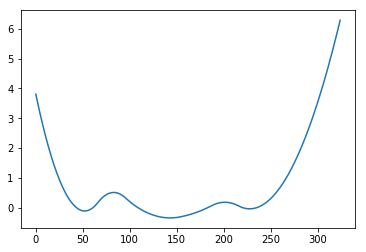

In [30]:
idx=0
plt.plot(splines_410[idx]-splines_470[idx])

In [31]:
mse = np.sum(np.power((splines_410 - splines_470), 2), axis=1)

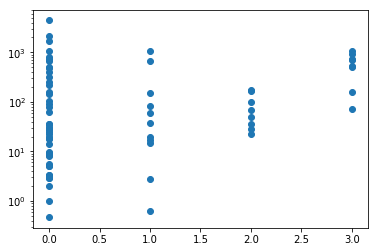

In [32]:
fig = plt.figure()
ax = plt.gca()

mask = mse<5000

ax.scatter(y[:75][mask], mse[mask])
ax.set_yscale('log')

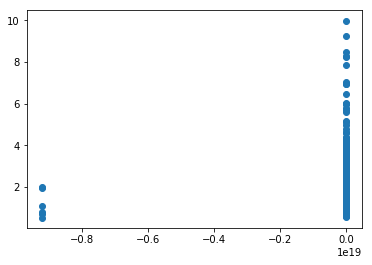

In [33]:
poly_410 = np.asarray([get_polyline(img, should_round=False)[:,1] for i, img in enumerate(cropped_410)])
poly_470 = np.asarray([get_polyline(img, should_round=False)[:,1] for i, img in enumerate(cropped_470)])
mse = np.sum(np.abs(poly_410[:,10:55] - poly_470[:,10:55]), axis=1)

fig = plt.figure()
ax = plt.gca()

ax.scatter(c_labels, mse)

In [34]:
np.shape(poly_410)

(1089, 65)

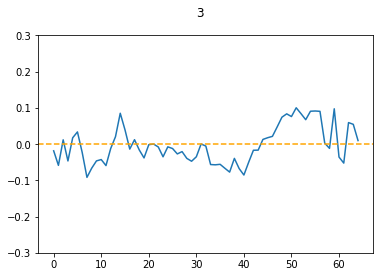

In [35]:
idx=0
fig = plt.figure()
ax = plt.gca()
ax.plot(poly_410[idx] - poly_470[idx])
fig.suptitle(c_labels[idx])
ax.set_ylim((-.3,.3))
ax.axhline(0, ls='--', c='orange')

In [36]:
poly_410.shape

(1089, 65)

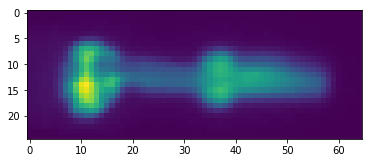

In [37]:
plt.imshow(cropped_410[6])

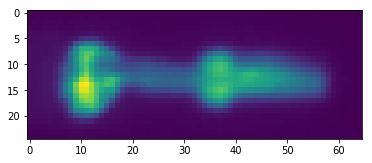

In [38]:
plt.imshow(cropped_470[6])

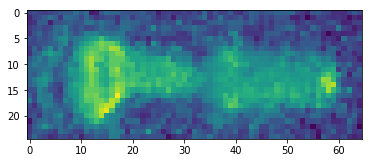

In [39]:
plt.imshow(r_410_470[6])

In [40]:
np.shape(poly_410[:,10:55])

(1089, 45)